### 환경설정
- rembg는 opencv랑 충돌일어남.
- mediapipe는 numpy < 2.0 필요 → numpy 1.23.5 추천
- moviepy는 numpy >= 1.25.0 필요 → numpy 1.23.5랑 충돌 발생 => moviepy는 영상처리 라이브러리이기 때문에 필요x, uninstall 진행

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp


얼굴 길이 (px): 43.56
얼굴 너비 (px): 87.86
턱선 각도: 1.50
키 (px): 852.11
어깨 너비 (px): 239.87
골반 너비 (px): 124.95
상체/전체 비율: 0.37
→ 추정 체형: 역삼각형
→ 추정 얼굴형: 육각형 (Hexagon)


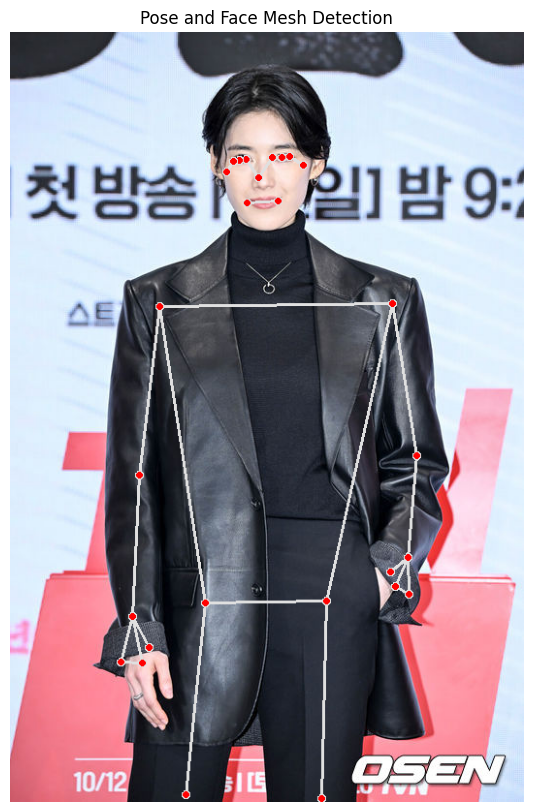

In [ ]:
# Mediapipe 설정
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# 이미지 로딩
image_path = "wjddmsco.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mediapipe로 관절 추출
pose_results = pose.process(image_rgb)
face_results = face_mesh.process(image_rgb)

pose_landmarks = pose_results.pose_landmarks
face_landmarks = face_results.multi_face_landmarks

if not pose_landmarks:
    print("사람을 감지하지 못했습니다.")
else:
    h, w, _ = image.shape
    def get_point(idx, landmarks):
        lm = landmarks.landmark[idx]
        return np.array([lm.x * w, lm.y * h])

    # 필요한 관절 위치 (Pose)
    l_shoulder = get_point(mp_pose.PoseLandmark.LEFT_SHOULDER, pose_landmarks)
    r_shoulder = get_point(mp_pose.PoseLandmark.RIGHT_SHOULDER, pose_landmarks)
    l_hip = get_point(mp_pose.PoseLandmark.LEFT_HIP, pose_landmarks)
    r_hip = get_point(mp_pose.PoseLandmark.RIGHT_HIP, pose_landmarks)
    nose = get_point(mp_pose.PoseLandmark.NOSE, pose_landmarks)
    ankle = get_point(mp_pose.PoseLandmark.LEFT_ANKLE, pose_landmarks)

    # 길이 및 너비 계산 (Pose)
    shoulder_width = np.linalg.norm(r_shoulder - l_shoulder)
    hip_width = np.linalg.norm(r_hip - l_hip)
    height = np.linalg.norm(nose - ankle)
    torso_length = np.linalg.norm(l_shoulder - l_hip)
    leg_length = np.linalg.norm(l_hip - ankle)
    waist_ratio = torso_length / height

    # 체형 분류 (Pose)
    shape = "분류 실패"
    if shoulder_width / hip_width > 1.2:
        shape = "역삼각형"
    elif hip_width / shoulder_width > 1.2:
        shape = "삼각형"
    elif abs(shoulder_width - hip_width) < 0.1 * shoulder_width:
        if waist_ratio < 0.45:
            shape = "모래시계형"
        else:
            shape = "직사각형"
    else:
        shape = "둥근형"

    # 얼굴형 추정 (Face Mesh)
    if face_landmarks:
        face_landmarks = face_landmarks[0].landmark  # 첫 번째 얼굴의 랜드마크 추출

        # 얼굴 길이 계산 (코 끝과 턱선의 거리)
        nose_tip = np.array([face_landmarks[1].x * w, face_landmarks[1].y * h])
        chin = np.array([face_landmarks[152].x * w, face_landmarks[152].y * h])
        face_length = np.linalg.norm(nose_tip - chin)

        # 얼굴 너비 계산 (좌우 광대의 거리)
        left_cheek = np.array([face_landmarks[234].x * w, face_landmarks[234].y * h])
        right_cheek = np.array([face_landmarks[454].x * w, face_landmarks[454].y * h])
        face_width = np.linalg.norm(left_cheek - right_cheek)

        # 턱선 각도 (간단한 예시로, 세 점을 이용)
        jaw_angle = np.arctan2(chin[1] - nose_tip[1], chin[0] - nose_tip[0])

        print(f"얼굴 길이 (px): {face_length:.2f}")
        print(f"얼굴 너비 (px): {face_width:.2f}")
        print(f"턱선 각도: {jaw_angle:.2f}")

        # 얼굴형 추정
        if abs(face_length - face_width) < 0.2 * face_length:
            face_shape = "계란형 (Oval)"
        elif jaw_angle < 0.3:  # 각도가 작으면 둥근 턱
            face_shape = "둥근형 (Round)"
        elif face_width / face_length > 1.2:  # 너비가 길이보다 크면
            face_shape = "육각형 (Hexagon)"
        elif face_width < 0.8 * face_length:  # 광대가 작은 경우
            face_shape = "마름모형 (Diamond)"
        elif jaw_angle > 0.3:  # 턱각도가 뚜렷하면
            face_shape = "하트형 (Heart)"
        else:
            face_shape = "기타"
    else:
        face_shape = "얼굴을 감지하지 못했습니다."
    # 얼굴형 감지 안 될 경우 체형만 출력

    # 결과 출력
    print(f"키 (px): {height:.2f}")
    print(f"어깨 너비 (px): {shoulder_width:.2f}")
    print(f"골반 너비 (px): {hip_width:.2f}")
    print(f"상체/전체 비율: {waist_ratio:.2f}")
    print(f"→ 추정 체형: {shape}")
    print(f"→ 추정 얼굴형: {face_shape}")

    # 관절 시각화
    annotated = image.copy()
    mp_drawing.draw_landmarks(annotated, pose_landmarks, mp_pose.POSE_CONNECTIONS)
    

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Pose and Face Mesh Detection")
    plt.show()

## 뒷배경 날리기

- mediapipe, numpy, rembg, backgroundremover => 버전 맞춰주기 너무 어려움
=> mediapipe도 배경제거 해주는 역할이 있긴 하지만, 사실 상체 위주라 잘되는진 모르겠으나,
일단 해볼 수 있는건 해보려고함. mediapipe말고 다른 걸로 배경 제거하려면, 결국 가상환경을 바꿔줘야함 or 파이프라인 통해서 프롬프트에서 피부색 추출하도록 해야함.CLI
 
     
- mediapipe로도 뒷배경 잘 사라짐. 뒤에 오브젝트들 있어도 괜찮게 되는듯함.

In [7]:
mp_selfie_segmentation = mp.solutions.selfie_segmentation

# 세그멘테이션 실행
with mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_segmentation:
    results = selfie_segmentation.process(image_rgb)
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.5
    bg_image = np.ones(image.shape, dtype=np.uint8) * 255
    output_image = np.where(condition, image, bg_image)


## 피부색 추출

1. 피부 영역 추출 (마스킹) – YCrCb 색공간 + 스킨 컬러 범위로 마스크
2. 마스크된 부분의 평균 RGB 추출
3. RGB → LAB 변환
4. LAB의 L(명도), a/b(색상+채도) 값 분석해서 퍼스널 컬러 진단


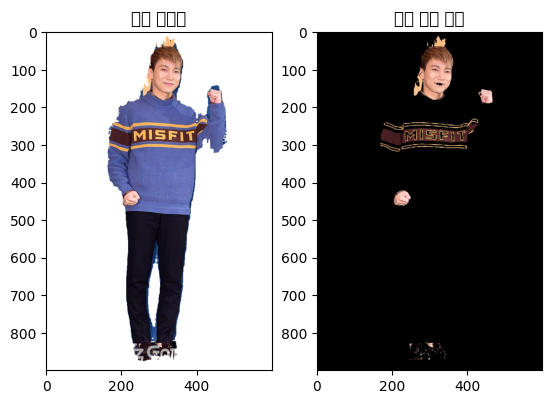

In [8]:
# BGR → RGB (OpenCV는 기본이 BGR)
img_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# YCrCb 색공간으로 변환
img_ycrcb = cv2.cvtColor(output_image, cv2.COLOR_BGR2YCrCb)

# # 히스토그램 평활화 (명도 보정)
# y, cr, cb = cv2.split(img_ycrcb)
# y_eq = cv2.equalizeHist(y)
# img_ycrcb_eq = cv2.merge([y_eq, cr, cb])
# img_rgb_eq = cv2.cvtColor(img_ycrcb_eq, cv2.COLOR_YCrCb2RGB)

# 피부색 범위 (YCrCb 기준, 조정 가능)
lower = np.array([0, 133, 77], dtype=np.uint8)
upper = np.array([255, 173, 127], dtype=np.uint8)
skin_mask = cv2.inRange(img_ycrcb, lower, upper)
# 마스크로 피부 추출
skin = cv2.bitwise_and(img_rgb, img_rgb, mask=skin_mask)

# # 평균 색상 추출
# skin_pixels = skin[skin_mask > 0]
# mean_color = np.mean(skin_pixels, axis=0) if len(skin_pixels) > 0 else [0, 0, 0]
    # 시각화
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("입력 이미지")

plt.subplot(1, 2, 2)
plt.imshow(skin)
plt.title("피부 검출 결과")
plt.show()

평균 L (명도): 134.08, a (적-녹): 145.59, b (청-황): 146.36
→ 추정 퍼스널 컬러: 봄 웜톤


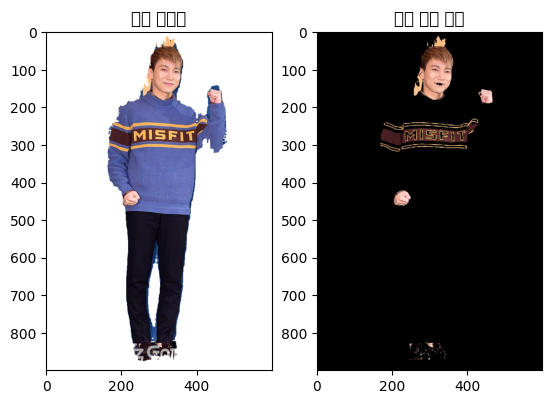

In [9]:
skin_lab = cv2.cvtColor(skin, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(skin_lab)

# 유효한 피부 픽셀만 골라 평균 계산
mask_indices = skin_mask > 0
L_mean = np.mean(L[mask_indices])
a_mean = np.mean(A[mask_indices])
b_mean = np.mean(B[mask_indices])

print(f"평균 L (명도): {L_mean:.2f}, a (적-녹): {a_mean:.2f}, b (청-황): {b_mean:.2f}")

def classify_season(L, a, b):
    if L > 75:
        if a < 130 and b < 135:
            return "여름 쿨톤"
        else:
            return "봄 웜톤"
    else:
        if a > 140 and b > 145:
            return "가을 웜톤"
        else:
            return "겨울 쿨톤"

season = classify_season(L_mean, a_mean, b_mean)
print(f"→ 추정 퍼스널 컬러: {season}")

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("입력 이미지")

plt.subplot(1, 2, 2)
plt.imshow(skin)
plt.title("피부 검출 결과")
plt.show()